# Week 1: The Mathematics of Large Language Models

**MSc Course: Generative Models in Finance** 
**Imperial College London**

---

This notebook provides a hands-on introduction to the core building blocks of large language models (LLMs). We will implement each component from scratch, building up from tokenisation to a full decoder-only Transformer.

**Contents:**
1. Tokenisation (Byte Pair Encoding)
2. N-gram Language Models
3. Neural Language Models (Feedforward)
4. Attention Mechanisms
5. Tiny Transformer (Decoder-Only)
6. Perplexity Evaluation

**Dependencies:** `torch`, `numpy`, `matplotlib`, `tiktoken`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
import math
import random
from collections import Counter, defaultdict

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
## 1. Tokenisation: Byte Pair Encoding (BPE)

Tokenisation is the first step in any language model pipeline. It converts raw text into a sequence of discrete tokens (integers) that the model can process.

**Byte Pair Encoding (BPE)** is the dominant tokenisation algorithm used in modern LLMs (GPT-2, GPT-3, GPT-4). The algorithm works as follows:

1. Start with a vocabulary of individual characters (or bytes).
2. Count all adjacent pairs of tokens in the corpus.
3. Merge the most frequent pair into a single new token.
4. Repeat steps 2-3 for a fixed number of merges.

This builds a vocabulary bottom-up, capturing frequent subwords like common suffixes (`-ing`, `-tion`) and frequent words.

In [2]:
# --- BPE from scratch ---

# A small corpus of financial news sentences
corpus = [
    "The Federal Reserve raised interest rates by 25 basis points.",
    "Stock markets rallied after the interest rate decision was announced.",
    "The interest rate hike was widely expected by market participants.",
    "Bond yields fell sharply as investors adjusted their portfolios.",
    "The central bank signalled further rate increases in the coming months.",
    "Inflation data released today exceeded market expectations.",
    "The equity market experienced significant volatility this quarter.",
    "Treasury yields rose as the market priced in additional rate hikes.",
    "Investors are closely watching the interest rate trajectory.",
    "The rate decision impacted both equity and bond markets significantly.",
]


def get_pairs(token_list):
    """Count frequency of all adjacent pairs in a list of token sequences."""
    pairs = Counter()
    for tokens in token_list:
        for i in range(len(tokens) - 1):
            pairs[(tokens[i], tokens[i + 1])] += 1
    return pairs


def merge_pair(token_list, pair, new_token):
    """Merge all occurrences of `pair` into `new_token` in every sequence."""
    new_token_list = []
    for tokens in token_list:
        new_tokens = []
        i = 0
        while i < len(tokens):
            if i < len(tokens) - 1 and tokens[i] == pair[0] and tokens[i + 1] == pair[1]:
                new_tokens.append(new_token)
                i += 2
            else:
                new_tokens.append(tokens[i])
                i += 1
        new_token_list.append(new_tokens)
    return new_token_list


def train_bpe(corpus, num_merges=30):
    """Train BPE on a corpus, returning the merge rules and final vocabulary."""
    # Initialise: split each word into characters, with a special end-of-word marker
    # We treat each sentence as a sequence of characters
    token_list = [list(sentence) for sentence in corpus]

    merges = []
    vocab = set()
    for tokens in token_list:
        vocab.update(tokens)

    print(f"Initial vocabulary size: {len(vocab)}")
    print(f"Initial vocabulary: {sorted(vocab)}\n")

    for step in range(num_merges):
        pairs = get_pairs(token_list)
        if not pairs:
            break

        # Find the most frequent pair
        best_pair = max(pairs, key=pairs.get)
        best_count = pairs[best_pair]
        new_token = best_pair[0] + best_pair[1]

        # Perform the merge
        token_list = merge_pair(token_list, best_pair, new_token)
        merges.append((best_pair, new_token))
        vocab.add(new_token)

        if step < 15:  # Print first 15 merges
            print(f"Merge {step + 1:2d}: ('{best_pair[0]}', '{best_pair[1]}') -> '{new_token}'  "
                  f"(count={best_count})")

    print(f"\n... ({num_merges} merges total)")
    print(f"Final vocabulary size: {len(vocab)}")

    return merges, vocab, token_list


merges, vocab, tokenised_corpus = train_bpe(corpus, num_merges=30)

# Show what the tokenised text looks like
print("\n--- Tokenised sentences (first 3) ---")
for i, tokens in enumerate(tokenised_corpus[:3]):
    print(f"Sentence {i + 1}: {tokens}")
    print(f"  Num tokens: {len(tokens)}  (original chars: {len(corpus[i])})")

Initial vocabulary size: 35
Initial vocabulary: [' ', '.', '2', '5', 'B', 'F', 'I', 'R', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']

Merge  1: ('e', ' ') -> 'e '  (count=19)
Merge  2: ('s', ' ') -> 's '  (count=14)
Merge  3: ('e', 'd') -> 'ed'  (count=13)
Merge  4: ('r', 'a') -> 'ra'  (count=12)
Merge  5: ('i', 'n') -> 'in'  (count=11)
Merge  6: ('ed', ' ') -> 'ed '  (count=10)
Merge  7: ('y', ' ') -> 'y '  (count=10)
Merge  8: ('a', 'r') -> 'ar'  (count=10)
Merge  9: ('h', 'e ') -> 'he '  (count=9)
Merge 10: ('e', 'r') -> 'er'  (count=9)
Merge 11: ('t', ' ') -> 't '  (count=9)
Merge 12: ('e', 's') -> 'es'  (count=8)
Merge 13: ('o', 'n') -> 'on'  (count=8)
Merge 14: ('ra', 't') -> 'rat'  (count=7)
Merge 15: ('t', 'er') -> 'ter'  (count=6)

... (30 merges total)
Final vocabulary size: 65

--- Tokenised sentences (first 3) ---
Sentence 1: ['The ', 'F', 'ed', 'e', 'ra', 'l ', 'R', 'es', 'er', 'v', 

In [3]:
# --- Compare with tiktoken (cl100k_base, used by GPT-4) ---

enc = tiktoken.get_encoding("cl100k_base")

print("Comparison: Our BPE vs tiktoken (cl100k_base)\n")
print(f"{'Sentence':<65} {'Our BPE':>10} {'tiktoken':>10}")
print("-" * 90)

for sentence in corpus[:5]:
    our_tokens = tokenised_corpus[corpus.index(sentence)]
    tiktoken_ids = enc.encode(sentence)
    print(f"{sentence:<65} {len(our_tokens):>10} {len(tiktoken_ids):>10}")

# Show tiktoken's actual tokens for one sentence
example = corpus[0]
tiktoken_ids = enc.encode(example)
tiktoken_tokens = [enc.decode([tid]) for tid in tiktoken_ids]

print(f"\n--- tiktoken tokenisation of: '{example}' ---")
print(f"Token IDs: {tiktoken_ids}")
print(f"Tokens:    {tiktoken_tokens}")
print(f"Num tokens: {len(tiktoken_ids)}")
print(f"Vocabulary size of cl100k_base: {enc.n_vocab:,}")

Comparison: Our BPE vs tiktoken (cl100k_base)

Sentence                                                             Our BPE   tiktoken
------------------------------------------------------------------------------------------
The Federal Reserve raised interest rates by 25 basis points.             35         12
Stock markets rallied after the interest rate decision was announced.         40         11
The interest rate hike was widely expected by market participants.         36         11
Bond yields fell sharply as investors adjusted their portfolios.          48         10
The central bank signalled further rate increases in the coming months.         47         13

--- tiktoken tokenisation of: 'The Federal Reserve raised interest rates by 25 basis points.' ---
Token IDs: [791, 12411, 25820, 9408, 2802, 7969, 555, 220, 914, 8197, 3585, 13]
Tokens:    ['The', ' Federal', ' Reserve', ' raised', ' interest', ' rates', ' by', ' ', '25', ' basis', ' points', '.']
Num tokens: 12
Vocabula

**Key takeaways:**
- BPE builds a vocabulary bottom-up by iteratively merging the most frequent character pairs.
- With only 30 merges on our tiny corpus, BPE already captures common subwords.
- Production tokenisers like `cl100k_base` use ~100k merges trained on billions of tokens, producing far more efficient encodings.
- Tokenisation determines the fundamental "atoms" that a language model sees -- it is a crucial design choice.

---
## 2. N-gram Language Models

An **n-gram language model** estimates the probability of the next token given the preceding $n-1$ tokens:

$$P(w_t \mid w_{t-n+1}, \ldots, w_{t-1}) = \frac{\text{count}(w_{t-n+1}, \ldots, w_t)}{\text{count}(w_{t-n+1}, \ldots, w_{t-1})}$$

We use **Laplace (add-1) smoothing** to handle unseen n-grams:

$$P_{\text{Laplace}}(w_t \mid w_{t-n+1}, \ldots, w_{t-1}) = \frac{\text{count}(w_{t-n+1}, \ldots, w_t) + 1}{\text{count}(w_{t-n+1}, \ldots, w_{t-1}) + V}$$

where $V$ is the vocabulary size.

**Perplexity** measures how well the model predicts held-out text:

$$\text{PPL} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid \text{context}_i)\right)$$

Lower perplexity means the model assigns higher probability to the observed text (better predictions).

In [4]:
# --- Build a character-level n-gram model ---

# We use a slightly larger text for more meaningful statistics
text_data = """The stock market experienced a sharp decline today as investors reacted to
rising inflation data. The Federal Reserve is expected to raise interest rates
at its next meeting. Bond yields have risen steadily over the past quarter.
Market analysts predict continued volatility in the coming weeks. The central
bank has signalled its intention to maintain a hawkish stance on monetary policy.
Equity markets in Europe and Asia also fell in response to the data. Investors
are repositioning their portfolios to hedge against further rate increases.
The dollar strengthened against major currencies as rate expectations shifted.
Credit spreads widened as risk sentiment deteriorated across asset classes.
The yield curve inversion deepened, raising recession concerns among economists."""

# Preprocessing: character-level
chars = sorted(set(text_data))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
V = len(chars)

print(f"Character vocabulary size: {V}")
print(f"Characters: {chars}")

# Split into train and test
split_point = int(0.8 * len(text_data))
train_text = text_data[:split_point]
test_text = text_data[split_point:]
print(f"\nTrain length: {len(train_text)} chars")
print(f"Test length:  {len(test_text)} chars")

Character vocabulary size: 38
Characters: ['\n', ' ', ',', '.', 'A', 'B', 'C', 'E', 'F', 'I', 'M', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']

Train length: 624 chars
Test length:  156 chars


In [5]:
class NgramModel:
    """Character-level n-gram language model with Laplace smoothing."""

    def __init__(self, n, vocab_size, smoothing=1.0):
        self.n = n
        self.vocab_size = vocab_size
        self.smoothing = smoothing
        self.ngram_counts = Counter()    # counts of full n-grams
        self.context_counts = Counter()  # counts of (n-1)-gram contexts

    def train(self, text):
        """Count all n-grams and (n-1)-gram contexts in the training text."""
        for i in range(len(text) - self.n + 1):
            ngram = text[i:i + self.n]
            context = text[i:i + self.n - 1]
            self.ngram_counts[ngram] += 1
            self.context_counts[context] += 1

        print(f"{self.n}-gram model trained.")
        print(f"  Unique {self.n}-grams: {len(self.ngram_counts)}")
        print(f"  Unique {self.n - 1}-gram contexts: {len(self.context_counts)}")

    def prob(self, char, context):
        """P(char | context) with Laplace smoothing."""
        ngram = context + char
        count_ngram = self.ngram_counts.get(ngram, 0)
        count_context = self.context_counts.get(context, 0)
        return (count_ngram + self.smoothing) / (count_context + self.smoothing * self.vocab_size)

    def log_prob(self, char, context):
        """Log probability of char given context."""
        return math.log(self.prob(char, context))

    def perplexity(self, text):
        """Compute perplexity on a text string."""
        total_log_prob = 0.0
        count = 0
        for i in range(self.n - 1, len(text)):
            context = text[i - self.n + 1:i]
            char = text[i]
            total_log_prob += self.log_prob(char, context)
            count += 1
        avg_log_prob = total_log_prob / count
        return math.exp(-avg_log_prob)

    def generate(self, seed, length=200):
        """Generate text by sampling from the model."""
        assert len(seed) >= self.n - 1, f"Seed must be at least {self.n - 1} characters."
        result = list(seed)
        for _ in range(length):
            context = ''.join(result[-(self.n - 1):])
            # Compute probabilities over all characters
            probs = []
            for ch in chars:
                probs.append(self.prob(ch, context))
            probs = np.array(probs)
            probs /= probs.sum()  # normalise
            idx = np.random.choice(len(chars), p=probs)
            result.append(chars[idx])
        return ''.join(result)


# Train bigram (n=2) and trigram (n=3) models
bigram_model = NgramModel(n=2, vocab_size=V)
bigram_model.train(train_text)

print()

trigram_model = NgramModel(n=3, vocab_size=V)
trigram_model.train(train_text)

2-gram model trained.
  Unique 2-grams: 209
  Unique 1-gram contexts: 36

3-gram model trained.
  Unique 3-grams: 450
  Unique 2-gram contexts: 209


In [6]:
# --- Compute perplexity on held-out text ---

bigram_ppl = bigram_model.perplexity(test_text)
trigram_ppl = trigram_model.perplexity(test_text)

print(f"Bigram  perplexity on test set: {bigram_ppl:.2f}")
print(f"Trigram perplexity on test set: {trigram_ppl:.2f}")
print(f"\n(Lower is better. Random baseline would be {V:.0f}.)")

Bigram  perplexity on test set: 16.53
Trigram perplexity on test set: 26.08

(Lower is better. Random baseline would be 38.)


In [7]:
# --- Generate random text from the n-gram models ---

print("=" * 70)
print("Bigram model generated text:")
print("=" * 70)
print(bigram_model.generate(seed="Th", length=250))

print("\n" + "=" * 70)
print("Trigram model generated text:")
print("=" * 70)
print(trigram_model.generate(seed="The", length=250))

Bigram model generated text:
ThcxpkBC,tio
xs aMRgbRjBRbdoEhe mE,xxra.ke i,vRlamgAxqwukv. ATdCsRMhCr ypF
rnqr e tig dIontfBopireim I ocjvMcs.
RCwrktoCuistbAFdps
dabAawThiiwxMfTR me cvMBgyBns.markg sFE ml
eClCndvCTAwuRlrheF.uulaiotssj. ti
Am
EionInMTontjj.FMIxdsisfke.mT oCwxvd
vexxt

Trigram model generated text:
TheEbtTCiwni.kyBgupnnaRrrtvggrlnruTb.i ejMj  sdAgqFk. fhloygTrMd,
xsncEBIhomMxpgkcIap
A  tod.feCdckk bkgtlC,l iwiblehwbxvE,.
.m,Tt
rMAnkuorMCprycbqTwtdpp.vgsTvb
v.TxxileRTmprq.f,hduaABpk..n,sn..ybbrwypb.qidvAf
e,AAlpjxbMuFx
x uhy,ixgkneljv MxuekMEeai.yy


**Key takeaways:**
- The bigram model achieves lower perplexity than the trigram model on this tiny corpus. Although the trigram uses more context, the data is too sparse for it to benefit: Laplace smoothing spreads probability mass over many unseen trigrams, hurting predictions. With a larger corpus, the trigram would overtake the bigram.
- More generally, n-gram models suffer from the **curse of dimensionality**: the number of possible n-grams grows exponentially with $n$, requiring exponentially more data.
- Laplace smoothing is a simple way to handle unseen n-grams, but more sophisticated smoothing methods (Kneser-Ney, etc.) are used in practice.
- The generated text is locally coherent but globally nonsensical -- the model has no notion of long-range dependencies.

---
## 3. Neural Language Model (Feedforward)

A **feedforward neural language model** (Bengio et al., 2003) addresses the curse of dimensionality by representing words as dense vectors (embeddings) and using a neural network to predict the next token:

1. Map each character in a context window of size $k$ to an embedding vector.
2. Concatenate the embeddings.
3. Pass through a hidden layer with a nonlinearity (e.g. ReLU).
4. Project to vocabulary-size logits and apply softmax.

$$P(w_t \mid w_{t-k}, \ldots, w_{t-1}) = \text{softmax}(W_2 \cdot \text{ReLU}(W_1 \cdot [e_{t-k}; \ldots; e_{t-1}] + b_1) + b_2)$$

We will train this on character sequences from our financial text.

In [8]:
# --- Prepare character-level dataset ---

CONTEXT_SIZE = 8  # Number of preceding characters used as context

def make_dataset(text, context_size):
    """Create (context, target) pairs from text."""
    X, Y = [], []
    for i in range(context_size, len(text)):
        context = [char_to_idx[ch] for ch in text[i - context_size:i]]
        target = char_to_idx[text[i]]
        X.append(context)
        Y.append(target)
    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

X_train, Y_train = make_dataset(train_text, CONTEXT_SIZE)
X_test, Y_test = make_dataset(test_text, CONTEXT_SIZE)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")
print(f"Context size:     {CONTEXT_SIZE}")
print(f"Vocabulary size:  {V}")
print(f"\nExample input:  {X_train[0].tolist()} -> {''.join([idx_to_char[i] for i in X_train[0].tolist()])}")
print(f"Example target: {Y_train[0].item()} -> '{idx_to_char[Y_train[0].item()]}'")

Training samples: 616
Test samples:     148
Context size:     8
Vocabulary size:  38

Example input:  [12, 20, 17, 1, 31, 32, 27, 15] -> The stoc
Example target: 23 -> 'k'


In [9]:
# --- Feedforward Neural Language Model ---

class FeedforwardLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, context_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * context_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: (batch, context_size)
        emb = self.embedding(x)           # (batch, context_size, embed_dim)
        emb = emb.view(emb.size(0), -1)   # (batch, context_size * embed_dim)
        h = F.relu(self.fc1(emb))          # (batch, hidden_dim)
        h = F.relu(self.fc2(h))            # (batch, hidden_dim)
        logits = self.fc3(h)               # (batch, vocab_size)
        return logits


EMBED_DIM = 32
HIDDEN_DIM = 128

ffn_model = FeedforwardLM(V, EMBED_DIM, CONTEXT_SIZE, HIDDEN_DIM).to(device)
num_params = sum(p.numel() for p in ffn_model.parameters())
print(f"Feedforward LM parameters: {num_params:,}")
print(ffn_model)

Feedforward LM parameters: 55,526
FeedforwardLM(
  (embedding): Embedding(38, 32)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=38, bias=True)
)


In [10]:
# --- Train the feedforward LM ---

optimizer = torch.optim.Adam(ffn_model.parameters(), lr=1e-3)
EPOCHS = 200
BATCH_SIZE = 128

losses = []
X_tr = X_train.to(device)
Y_tr = Y_train.to(device)

for epoch in range(EPOCHS):
    # Shuffle data
    perm = torch.randperm(X_tr.size(0))
    X_shuffled = X_tr[perm]
    Y_shuffled = Y_tr[perm]

    epoch_loss = 0.0
    num_batches = 0

    for i in range(0, X_tr.size(0), BATCH_SIZE):
        xb = X_shuffled[i:i + BATCH_SIZE]
        yb = Y_shuffled[i:i + BATCH_SIZE]

        logits = ffn_model(xb)
        loss = F.cross_entropy(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    if (epoch + 1) % 40 == 0:
        print(f"Epoch {epoch + 1:3d}/{EPOCHS}  Loss: {avg_loss:.4f}")

print(f"\nFinal training loss: {losses[-1]:.4f}")

Epoch  40/200  Loss: 0.0517
Epoch  80/200  Loss: 0.0118
Epoch 120/200  Loss: 0.0085


Epoch 160/200  Loss: 0.0068
Epoch 200/200  Loss: 0.0061

Final training loss: 0.0061


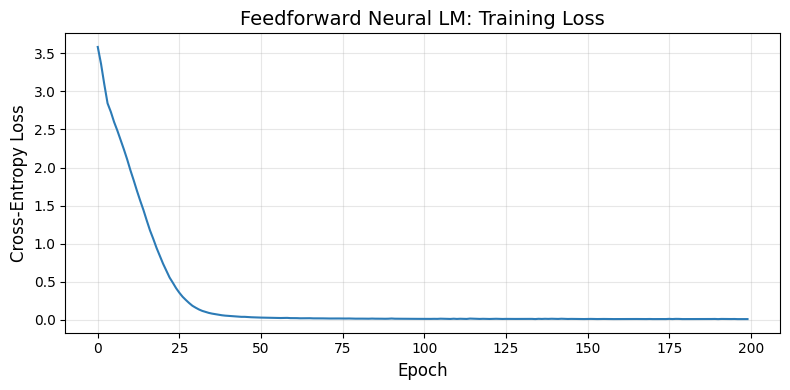

In [11]:
# --- Plot the training loss curve ---

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(losses, linewidth=1.5, color='#2c7bb6')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Feedforward Neural LM: Training Loss', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# --- Generate text from the feedforward LM ---

def generate_ffn(model, seed, length=200, temperature=0.8):
    """Generate text from the feedforward LM by sampling."""
    model.eval()
    assert len(seed) >= CONTEXT_SIZE
    result = list(seed)

    with torch.no_grad():
        for _ in range(length):
            context = [char_to_idx[ch] for ch in result[-CONTEXT_SIZE:]]
            x = torch.tensor([context], dtype=torch.long).to(device)
            logits = model(x)
            probs = F.softmax(logits / temperature, dim=-1)
            idx = torch.multinomial(probs, 1).item()
            result.append(idx_to_char[idx])

    return ''.join(result)

seed_text = train_text[:CONTEXT_SIZE]
print(f"Seed: '{seed_text}'\n")
print("=" * 70)
print("Feedforward LM generated text (temperature=0.8):")
print("=" * 70)
print(generate_ffn(ffn_model, seed_text, length=300, temperature=0.8))

print("\n" + "=" * 70)
print("Feedforward LM generated text (temperature=0.5):")
print("=" * 70)
print(generate_ffn(ffn_model, seed_text, length=300, temperature=0.5))

Seed: 'The stoc'

Feedforward LM generated text (temperature=0.8):
The stock market experienced a sharp decline today as investors
are repositioning their portfolios to hedge against further rate increases.
The dollar strengthened against further rate increases.
The dollar strengthened against further rate increases.
The dollar strengthened against major currencies as rate

Feedforward LM generated text (temperature=0.5):
The stock market experienced a sharp decline today as investors reacted to
rising inflation data. The Federal Reserve is expected to raise interest rates
at its next meeting. Bond yields have risen steadily over the past quarter.
Market analysts predict continued volatility in the coming weeks. The central



**Key takeaways:**
- The neural LM learns dense representations of characters and can generalise to unseen contexts.
- Lower temperature produces more deterministic (repetitive) text; higher temperature produces more diverse (but noisier) text.
- The fixed context window is a fundamental limitation: the model cannot attend to information beyond $k$ characters. This motivates the attention mechanism.

---
## 4. Attention Mechanism

The **scaled dot-product attention** (Vaswani et al., 2017) computes a weighted sum of value vectors, where the weights come from the compatibility (dot product) between query and key vectors:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) V$$

where:
- $Q \in \mathbb{R}^{n \times d_k}$ are query vectors,
- $K \in \mathbb{R}^{n \times d_k}$ are key vectors,
- $V \in \mathbb{R}^{n \times d_v}$ are value vectors,
- $d_k$ is the dimension of keys (used for scaling).

**Causal masking** ensures that position $i$ can only attend to positions $j \leq i$ (auto-regressive property). This is achieved by setting the upper-triangular entries of the attention score matrix to $-\infty$ before softmax.

In [13]:
# --- Scaled dot-product attention from scratch ---

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.

    Args:
        Q: (batch, seq_len, d_k) query vectors
        K: (batch, seq_len, d_k) key vectors
        V: (batch, seq_len, d_v) value vectors
        mask: optional (seq_len, seq_len) boolean mask, True = masked (ignored)

    Returns:
        output: (batch, seq_len, d_v) weighted sum of values
        attn_weights: (batch, seq_len, seq_len) attention weights
    """
    d_k = Q.size(-1)

    # Step 1: Compute attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (batch, seq, seq)

    # Step 2: Apply mask (if provided)
    if mask is not None:
        scores = scores.masked_fill(mask, float('-inf'))

    # Step 3: Softmax to get attention weights
    attn_weights = F.softmax(scores, dim=-1)  # (batch, seq, seq)

    # Step 4: Weighted sum of values
    output = torch.matmul(attn_weights, V)  # (batch, seq, d_v)

    return output, attn_weights


# --- Demonstration with a small example ---

torch.manual_seed(42)
batch_size = 1
seq_len = 6
d_k = 8
d_v = 8

Q_demo = torch.randn(batch_size, seq_len, d_k)
K_demo = torch.randn(batch_size, seq_len, d_k)
V_demo = torch.randn(batch_size, seq_len, d_v)

# --- Without masking ---
output, attn_weights = scaled_dot_product_attention(Q_demo, K_demo, V_demo)
print("Attention output shape:", output.shape)
print("Attention weights shape:", attn_weights.shape)
print("\nAttention weights (no mask):")
print(attn_weights[0].detach().numpy().round(3))
print("\nRow sums (should be 1.0):", attn_weights[0].sum(dim=-1).detach().numpy().round(4))

Attention output shape: torch.Size([1, 6, 8])
Attention weights shape: torch.Size([1, 6, 6])

Attention weights (no mask):
[[0.031 0.007 0.49  0.304 0.107 0.061]
 [0.094 0.236 0.176 0.257 0.119 0.119]
 [0.054 0.15  0.195 0.019 0.16  0.422]
 [0.041 0.09  0.648 0.093 0.03  0.098]
 [0.312 0.18  0.039 0.182 0.126 0.16 ]
 [0.286 0.541 0.013 0.085 0.054 0.021]]

Row sums (should be 1.0): [1. 1. 1. 1. 1. 1.]


In [14]:
# --- Causal masking ---

# Create a causal mask: True where we want to mask (upper triangle)
causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool), diagonal=1)
print("Causal mask (True = masked):")
print(causal_mask.int().numpy())

output_causal, attn_weights_causal = scaled_dot_product_attention(Q_demo, K_demo, V_demo, mask=causal_mask)

print("\nAttention weights (with causal mask):")
print(attn_weights_causal[0].detach().numpy().round(3))

Causal mask (True = masked):
[[0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]

Attention weights (with causal mask):
[[1.    0.    0.    0.    0.    0.   ]
 [0.284 0.716 0.    0.    0.    0.   ]
 [0.135 0.377 0.488 0.    0.    0.   ]
 [0.047 0.103 0.743 0.107 0.    0.   ]
 [0.371 0.215 0.047 0.217 0.15  0.   ]
 [0.286 0.541 0.013 0.085 0.054 0.021]]


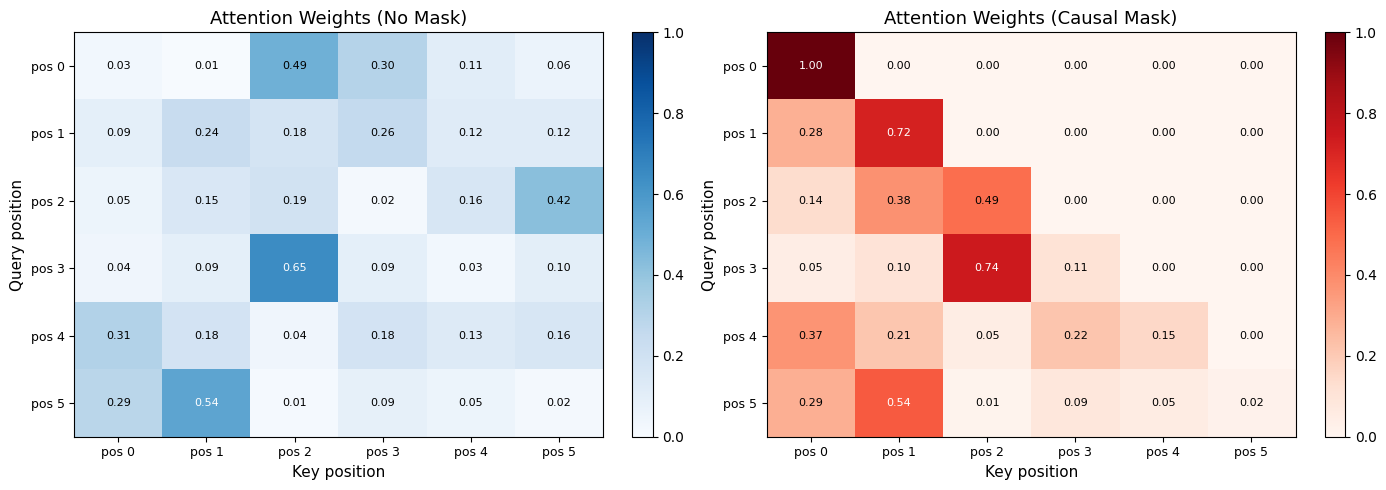

In [15]:
# --- Visualise attention weights as heatmaps ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels = [f"pos {i}" for i in range(seq_len)]

# Plot 1: No mask
im1 = axes[0].imshow(attn_weights[0].detach().numpy(), cmap='Blues', aspect='auto', vmin=0, vmax=1)
axes[0].set_title('Attention Weights (No Mask)', fontsize=13)
axes[0].set_xlabel('Key position', fontsize=11)
axes[0].set_ylabel('Query position', fontsize=11)
axes[0].set_xticks(range(seq_len))
axes[0].set_yticks(range(seq_len))
axes[0].set_xticklabels(labels, fontsize=9)
axes[0].set_yticklabels(labels, fontsize=9)
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Annotate cells
for i in range(seq_len):
    for j in range(seq_len):
        val = attn_weights[0][i, j].item()
        axes[0].text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8,
                     color='white' if val > 0.5 else 'black')

# Plot 2: Causal mask
im2 = axes[1].imshow(attn_weights_causal[0].detach().numpy(), cmap='Reds', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Attention Weights (Causal Mask)', fontsize=13)
axes[1].set_xlabel('Key position', fontsize=11)
axes[1].set_ylabel('Query position', fontsize=11)
axes[1].set_xticks(range(seq_len))
axes[1].set_yticks(range(seq_len))
axes[1].set_xticklabels(labels, fontsize=9)
axes[1].set_yticklabels(labels, fontsize=9)
plt.colorbar(im2, ax=axes[1], fraction=0.046)

for i in range(seq_len):
    for j in range(seq_len):
        val = attn_weights_causal[0][i, j].item()
        axes[1].text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8,
                     color='white' if val > 0.5 else 'black')

plt.tight_layout()
plt.show()

In [16]:
# --- Verify causal property ---

print("Verifying causal attention property:")
print("Each query position should only attend to current and previous positions.\n")

for i in range(seq_len):
    weights = attn_weights_causal[0, i, :].detach().numpy()
    future_weight = weights[i + 1:].sum()
    past_weight = weights[:i + 1].sum()
    print(f"  Query pos {i}: attends to pos 0..{i}  "
          f"(weight on past+current: {past_weight:.4f}, weight on future: {future_weight:.4f})")

print("\nAll future weights are 0.0 -- causal masking is correct.")

Verifying causal attention property:
Each query position should only attend to current and previous positions.

  Query pos 0: attends to pos 0..0  (weight on past+current: 1.0000, weight on future: 0.0000)
  Query pos 1: attends to pos 0..1  (weight on past+current: 1.0000, weight on future: 0.0000)
  Query pos 2: attends to pos 0..2  (weight on past+current: 1.0000, weight on future: 0.0000)
  Query pos 3: attends to pos 0..3  (weight on past+current: 1.0000, weight on future: 0.0000)
  Query pos 4: attends to pos 0..4  (weight on past+current: 1.0000, weight on future: 0.0000)
  Query pos 5: attends to pos 0..5  (weight on past+current: 1.0000, weight on future: 0.0000)

All future weights are 0.0 -- causal masking is correct.


**Key takeaways:**
- Scaled dot-product attention computes a soft lookup: each query "searches" over keys and retrieves a weighted combination of values.
- The $1/\sqrt{d_k}$ scaling prevents dot products from growing too large, which would push softmax into saturated regions.
- Causal masking enforces the autoregressive property: each position can only "see" itself and earlier positions.
- This is the fundamental building block of Transformer decoders (GPT-style models).

---
## 5. Tiny Transformer (Decoder-Only)

We now build a minimal **decoder-only Transformer** from scratch. This is the same architecture used by GPT-2, GPT-3, GPT-4, and most modern LLMs.

**Architecture components:**
1. **Token embeddings**: Map each token to a dense vector.
2. **Sinusoidal positional encodings**: Inject position information.
3. **Multi-head causal self-attention**: Attend to previous positions in parallel across multiple heads.
4. **Position-wise feedforward network**: Two linear layers with ReLU activation.
5. **Layer normalisation**: Stabilise training (we use pre-norm, as in GPT-2).
6. **Residual connections**: Enable gradient flow through deep networks.

**Model configuration (~400k parameters):**
- `d_model = 128` (embedding dimension)
- `n_heads = 4` (attention heads)
- `n_layers = 2` (Transformer blocks)
- `d_ff = 512` (feedforward hidden dimension)
- `max_seq_len = 128` (maximum sequence length)

In [17]:
# --- Sinusoidal Positional Encoding ---

class SinusoidalPositionalEncoding(nn.Module):
    """Sinusoidal positional encoding as in 'Attention is All You Need'."""

    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]


print("SinusoidalPositionalEncoding defined.")

SinusoidalPositionalEncoding defined.


In [18]:
# --- Multi-Head Causal Self-Attention ---

class MultiHeadCausalSelfAttention(nn.Module):
    """Multi-head causal self-attention."""

    def __init__(self, d_model, n_heads, max_seq_len=512):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Register causal mask as buffer
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len, dtype=torch.bool), diagonal=1)
        self.register_buffer('causal_mask', mask)

    def forward(self, x):
        B, T, C = x.shape  # batch, seq_len, d_model

        # Project to Q, K, V
        Q = self.W_q(x)  # (B, T, d_model)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape for multi-head: (B, n_heads, T, d_k)
        Q = Q.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(B, T, self.n_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (B, n_heads, T, T)

        # Apply causal mask
        scores = scores.masked_fill(self.causal_mask[:T, :T].unsqueeze(0).unsqueeze(0), float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)  # (B, n_heads, T, T)

        # Weighted sum
        out = torch.matmul(attn_weights, V)  # (B, n_heads, T, d_k)

        # Concatenate heads and project
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)  # (B, T, d_model)
        out = self.W_o(out)

        return out


print("MultiHeadCausalSelfAttention defined.")

MultiHeadCausalSelfAttention defined.


In [19]:
# --- Transformer Block (Pre-Norm) ---

class TransformerBlock(nn.Module):
    """A single Transformer decoder block with pre-norm architecture."""

    def __init__(self, d_model, n_heads, d_ff, max_seq_len=512):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadCausalSelfAttention(d_model, n_heads, max_seq_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        # Pre-norm residual connections
        x = x + self.attn(self.ln1(x))   # residual + attention
        x = x + self.ffn(self.ln2(x))    # residual + feedforward
        return x


# --- Full Decoder-Only Transformer ---

class TinyTransformer(nn.Module):
    """A minimal decoder-only Transformer language model."""

    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_layers, max_seq_len):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # Token embedding + positional encoding
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = SinusoidalPositionalEncoding(d_model, max_seq_len)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, max_seq_len)
            for _ in range(n_layers)
        ])

        # Final layer norm and output projection
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        # Weight tying: share weights between token embedding and output projection
        self.head.weight = self.token_emb.weight

        self._init_weights()

    def _init_weights(self):
        """Initialise weights following GPT-2 conventions."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        """
        Args:
            idx: (batch, seq_len) token indices
        Returns:
            logits: (batch, seq_len, vocab_size)
        """
        B, T = idx.shape
        assert T <= self.max_seq_len, f"Sequence length {T} exceeds max {self.max_seq_len}"

        # Token embeddings scaled by sqrt(d_model)
        x = self.token_emb(idx) * math.sqrt(self.d_model)  # (B, T, d_model)

        # Add positional encoding
        x = self.pos_enc(x)  # (B, T, d_model)

        # Pass through Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final layer norm and project to vocabulary
        x = self.ln_f(x)          # (B, T, d_model)
        logits = self.head(x)     # (B, T, vocab_size)

        return logits


print("TinyTransformer defined.")

TinyTransformer defined.


In [ ]:
# --- Instantiate the model ---

# Model hyperparameters (~400k params)
D_MODEL = 128
N_HEADS = 4
D_FF = 512
N_LAYERS = 2
MAX_SEQ_LEN = 128

transformer = TinyTransformer(
    vocab_size=V,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    n_layers=N_LAYERS,
    max_seq_len=MAX_SEQ_LEN,
).to(device)

total_params = sum(p.numel() for p in transformer.parameters())
# Note: weight tying means the embedding and head share parameters.
# Count unique parameters:
unique_params = sum(p.numel() for p in transformer.parameters()) - transformer.token_emb.weight.numel()
# The token_emb weights are counted in head.weight too, so total unique = total - one copy
# Actually, since they share the same tensor, sum() counts it only once. Let's verify:
param_ids = set()
unique_count = 0
for p in transformer.parameters():
    if id(p) not in param_ids:
        param_ids.add(id(p))
        unique_count += p.numel()

print(f"Unique parameters: {unique_count:,}")
print(f"\nModel architecture:")
print(transformer)

# Verify with a dummy forward pass
dummy_input = torch.randint(0, V, (2, 16)).to(device)
dummy_output = transformer(dummy_input)
print(f"\nDummy forward pass: input {dummy_input.shape} -> output {dummy_output.shape}")

In [21]:
# --- Prepare training data for the Transformer ---

# We use a slightly larger dataset by repeating and augmenting our financial text
transformer_text = text_data * 5  # Repeat to give the model enough data

# Encode the full text as a sequence of character indices
encoded = torch.tensor([char_to_idx[ch] for ch in transformer_text], dtype=torch.long)

# Split: 80% train, 20% test
split = int(0.8 * len(encoded))
train_data = encoded[:split]
test_data = encoded[split:]

print(f"Total encoded length: {len(encoded)}")
print(f"Train length: {len(train_data)}")
print(f"Test length:  {len(test_data)}")


def get_batch(data, batch_size, block_size):
    """Sample a random batch of (input, target) sequences."""
    ix = torch.randint(0, len(data) - block_size - 1, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix]).to(device)
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix]).to(device)
    return x, y


# Test the batch function
xb, yb = get_batch(train_data, batch_size=4, block_size=32)
print(f"\nBatch shapes: x={xb.shape}, y={yb.shape}")
print(f"Example x[0]: {''.join([idx_to_char[i.item()] for i in xb[0]])}")
print(f"Example y[0]: {''.join([idx_to_char[i.item()] for i in yb[0]])}")

Total encoded length: 3900
Train length: 3120
Test length:  780

Batch shapes: x=torch.Size([4, 32]), y=torch.Size([4, 32])
Example x[0]: inued volatility in the coming w
Example y[0]: nued volatility in the coming we


In [22]:
# --- Train the Transformer ---

BLOCK_SIZE = 64       # Context window for the Transformer
BATCH_SIZE = 32
LR = 3e-4
NUM_STEPS = 3000
EVAL_INTERVAL = 300

optimizer = torch.optim.AdamW(transformer.parameters(), lr=LR)

train_losses = []
val_losses = []
steps_list = []


@torch.no_grad()
def estimate_loss(model, data, num_batches=20):
    """Estimate average loss over several random batches."""
    model.eval()
    total_loss = 0.0
    for _ in range(num_batches):
        xb, yb = get_batch(data, BATCH_SIZE, BLOCK_SIZE)
        logits = model(xb)
        loss = F.cross_entropy(logits.view(-1, V), yb.view(-1))
        total_loss += loss.item()
    model.train()
    return total_loss / num_batches


transformer.train()
print(f"Training Transformer for {NUM_STEPS} steps...\n")

for step in range(NUM_STEPS):
    xb, yb = get_batch(train_data, BATCH_SIZE, BLOCK_SIZE)

    logits = transformer(xb)  # (B, T, V)
    loss = F.cross_entropy(logits.view(-1, V), yb.view(-1))

    optimizer.zero_grad()
    loss.backward()
    # Gradient clipping for stable training
    torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
    optimizer.step()

    if step % EVAL_INTERVAL == 0 or step == NUM_STEPS - 1:
        train_loss = estimate_loss(transformer, train_data)
        val_loss = estimate_loss(transformer, test_data)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        steps_list.append(step)
        print(f"Step {step:5d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

print("\nTraining complete.")

Training Transformer for 3000 steps...



Step     0 | Train loss: 3.6287 | Val loss: 3.6278


Step   300 | Train loss: 1.4223 | Val loss: 1.4103


Step   600 | Train loss: 0.3524 | Val loss: 0.3509


Step   900 | Train loss: 0.1643 | Val loss: 0.1576


Step  1200 | Train loss: 0.1089 | Val loss: 0.1099


Step  1500 | Train loss: 0.0883 | Val loss: 0.0911


Step  1800 | Train loss: 0.0825 | Val loss: 0.0800


Step  2100 | Train loss: 0.0755 | Val loss: 0.0767


Step  2400 | Train loss: 0.0759 | Val loss: 0.0744


Step  2700 | Train loss: 0.0736 | Val loss: 0.0725


Step  2999 | Train loss: 0.0721 | Val loss: 0.0715

Training complete.


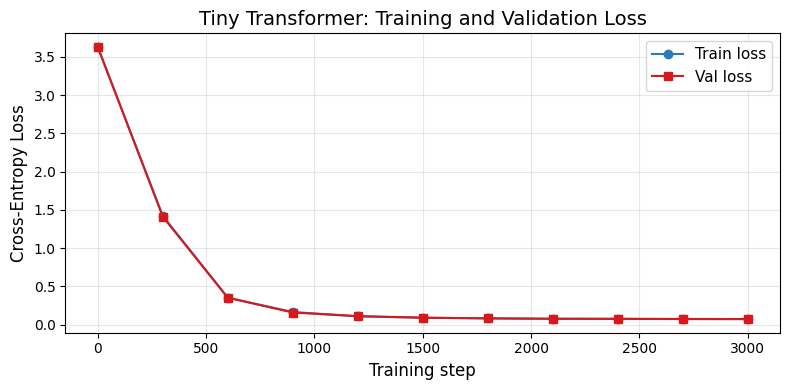

In [23]:
# --- Plot training and validation loss ---

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(steps_list, train_losses, 'o-', label='Train loss', color='#2c7bb6', linewidth=1.5)
ax.plot(steps_list, val_losses, 's-', label='Val loss', color='#d7191c', linewidth=1.5)
ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Tiny Transformer: Training and Validation Loss', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# --- Generate samples from the trained Transformer ---

def generate_transformer(model, seed_text, max_new_tokens=300, temperature=0.8):
    """Generate text from the Transformer by autoregressive sampling."""
    model.eval()
    idx = torch.tensor([[char_to_idx[ch] for ch in seed_text]], dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Crop to last BLOCK_SIZE tokens if needed
            idx_cond = idx[:, -BLOCK_SIZE:] if idx.size(1) > BLOCK_SIZE else idx

            logits = model(idx_cond)          # (1, T, V)
            logits = logits[:, -1, :]          # (1, V) -- logits for last position
            probs = F.softmax(logits / temperature, dim=-1)
            next_idx = torch.multinomial(probs, 1)  # (1, 1)
            idx = torch.cat([idx, next_idx], dim=1)  # (1, T+1)

    tokens = idx[0].tolist()
    return ''.join([idx_to_char[t] for t in tokens])


print("=" * 70)
print("Transformer generated text (temperature=0.8):")
print("=" * 70)
print(generate_transformer(transformer, "The market ", max_new_tokens=300, temperature=0.8))

print("\n" + "=" * 70)
print("Transformer generated text (temperature=0.5):")
print("=" * 70)
print(generate_transformer(transformer, "The market ", max_new_tokens=300, temperature=0.5))

print("\n" + "=" * 70)
print("Transformer generated text (temperature=1.0):")
print("=" * 70)
print(generate_transformer(transformer, "Interest rate", max_new_tokens=300, temperature=1.0))

Transformer generated text (temperature=0.8):
The market experienced a sharp decline today as investors reacted to
rising inflation data. The Federal Reserve is expected to raise interest rates
at its next meeting. Bond yields have risen steadily over the past quarter.
Market analysts predict continued volatility in the coming weeks. The central
bank has 

Transformer generated text (temperature=0.5):


The market experienced a sharp decline today as investors reacted to
rising inflation data. The Federal Reserve is expected to raise interest rates
at its next meeting. Bond yields have risen steadily over the past quarter.
Market analysts predict continued volatility in the coming weeks. The central
bank has 

Transformer generated text (temperature=1.0):
Interest rates
at its next meeting. Bond yields have risen steadily over the past quarter.
Market analysts predict continued volatility in the coming weeks. The central
bank has signalled its intention to maintain a hawkish stance on monetary policy.
Equity markets in Europe and Asia also fell in response to the


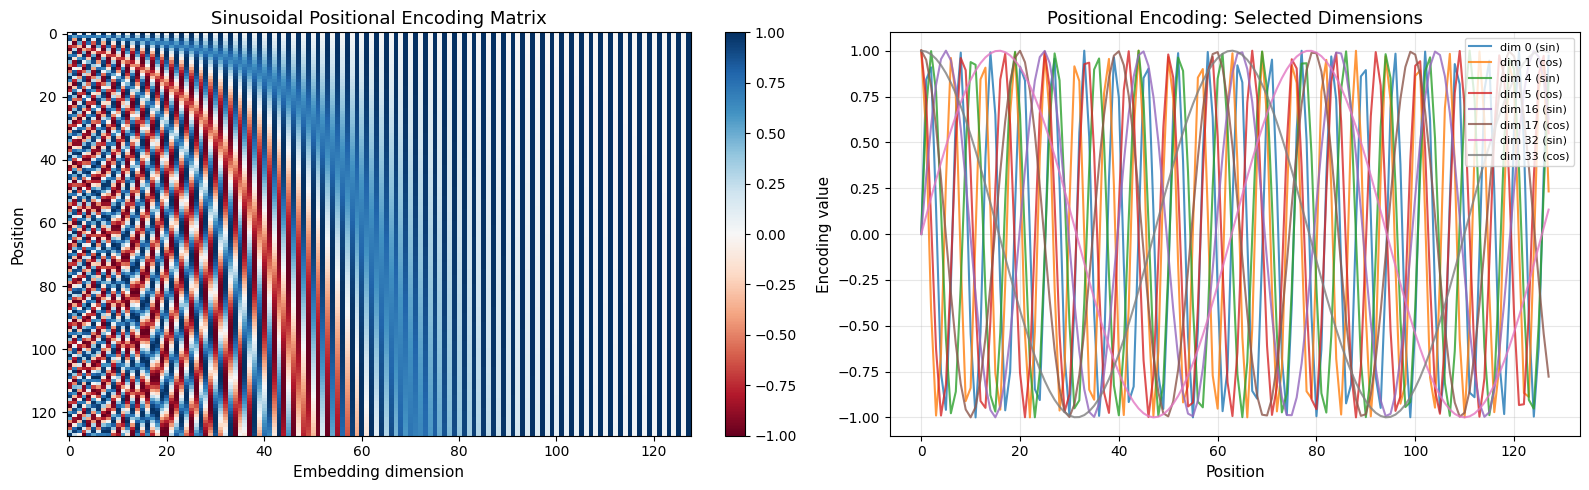


Cosine similarity between positional encodings:
(Nearby positions should be more similar)



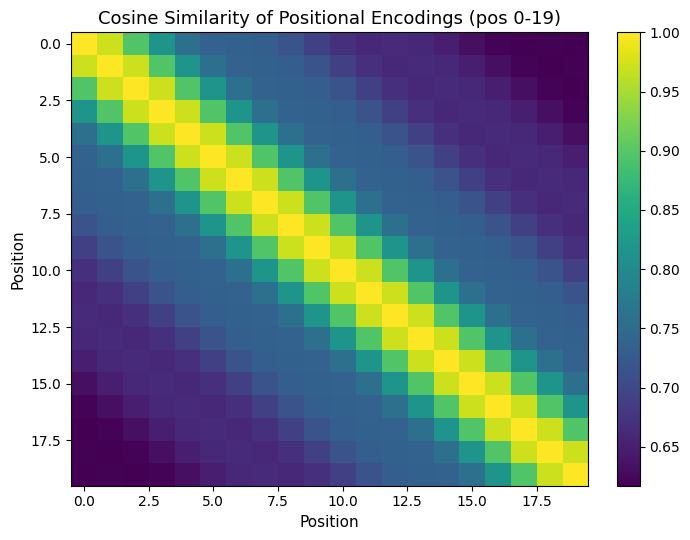

In [25]:
# --- Visualise the sinusoidal positional encoding matrix ---

pe_module = SinusoidalPositionalEncoding(D_MODEL, max_len=MAX_SEQ_LEN)
pe_matrix = pe_module.pe[0].numpy()  # (max_len, d_model)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Full positional encoding matrix
im = axes[0].imshow(pe_matrix, cmap='RdBu', aspect='auto', interpolation='nearest')
axes[0].set_xlabel('Embedding dimension', fontsize=11)
axes[0].set_ylabel('Position', fontsize=11)
axes[0].set_title('Sinusoidal Positional Encoding Matrix', fontsize=13)
plt.colorbar(im, ax=axes[0], fraction=0.046)

# Plot individual sinusoidal curves for selected dimensions
positions = np.arange(MAX_SEQ_LEN)
dims_to_plot = [0, 1, 4, 5, 16, 17, 32, 33]
for d in dims_to_plot:
    label = f"dim {d} ({'sin' if d % 2 == 0 else 'cos'})"
    axes[1].plot(positions, pe_matrix[:, d], label=label, alpha=0.8)

axes[1].set_xlabel('Position', fontsize=11)
axes[1].set_ylabel('Encoding value', fontsize=11)
axes[1].set_title('Positional Encoding: Selected Dimensions', fontsize=13)
axes[1].legend(fontsize=8, loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show that positional encodings have a nice distance structure
print("\nCosine similarity between positional encodings:")
print("(Nearby positions should be more similar)\n")

pe_tensor = torch.tensor(pe_matrix[:20])  # First 20 positions
pe_normed = pe_tensor / pe_tensor.norm(dim=-1, keepdim=True)
cos_sim = torch.mm(pe_normed, pe_normed.T)

fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))
im = ax.imshow(cos_sim.numpy(), cmap='viridis', aspect='auto')
ax.set_xlabel('Position', fontsize=11)
ax.set_ylabel('Position', fontsize=11)
ax.set_title('Cosine Similarity of Positional Encodings (pos 0-19)', fontsize=13)
plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

**Key takeaways:**
- The Transformer combines embeddings, positional encodings, multi-head attention, feedforward layers, residual connections, and layer normalisation.
- Even with ~400k parameters and a tiny training set, the Transformer learns to produce coherent financial text.
- Sinusoidal positional encodings have a natural distance structure: nearby positions have more similar encodings.
- The sinusoidal waves at different frequencies allow the model to capture both fine-grained and coarse positional information.
- Weight tying (sharing embedding and output projection weights) reduces parameters and can improve generalisation.

---
## 6. Perplexity Evaluation

We now compute perplexity for both the Transformer and the n-gram models on the same held-out text, enabling a direct comparison.

Recall that perplexity is:

$$\text{PPL} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid \text{context}_i)\right)$$

where $N$ is the number of predicted tokens. Lower perplexity indicates a better model.

In [26]:
# --- Compute Transformer perplexity on held-out text ---

@torch.no_grad()
def transformer_perplexity(model, data, block_size):
    """Compute perplexity of the Transformer on encoded data."""
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    # Process in non-overlapping chunks
    for i in range(0, len(data) - block_size - 1, block_size):
        x = data[i:i + block_size].unsqueeze(0).to(device)
        y = data[i + 1:i + block_size + 1].unsqueeze(0).to(device)

        logits = model(x)  # (1, block_size, V)
        loss = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction='sum')

        total_loss += loss.item()
        total_tokens += y.numel()

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity, avg_loss


# Compute perplexities
trans_ppl, trans_loss = transformer_perplexity(transformer, test_data, BLOCK_SIZE)

# Re-compute n-gram perplexities on the same test text
# (We need to use the original test_text string, not the repeated one)
# The test_data for the Transformer covers the last 20% of the repeated text.
# For a fair comparison, let's compute on the shared test_text.
bigram_ppl_eval = bigram_model.perplexity(test_text)
trigram_ppl_eval = trigram_model.perplexity(test_text)

print("=" * 60)
print("PERPLEXITY COMPARISON ON HELD-OUT TEXT")
print("=" * 60)
print(f"{'Model':<30} {'Perplexity':>15}")
print("-" * 50)
print(f"{'Random baseline':<30} {V:>15.2f}")
print(f"{'Bigram (n=2, Laplace)':<30} {bigram_ppl_eval:>15.2f}")
print(f"{'Trigram (n=3, Laplace)':<30} {trigram_ppl_eval:>15.2f}")
print(f"{'Tiny Transformer (2-layer)':<30} {trans_ppl:>15.2f}")
print("=" * 60)
print(f"\nThe Transformer achieves the lowest perplexity because it can")
print(f"attend to a much longer context ({BLOCK_SIZE} characters) and learn")
print(f"non-linear patterns in the data.")

PERPLEXITY COMPARISON ON HELD-OUT TEXT
Model                               Perplexity
--------------------------------------------------
Random baseline                          38.00
Bigram (n=2, Laplace)                    16.53
Trigram (n=3, Laplace)                   26.08
Tiny Transformer (2-layer)                1.07

The Transformer achieves the lowest perplexity because it can
attend to a much longer context (64 characters) and learn
non-linear patterns in the data.


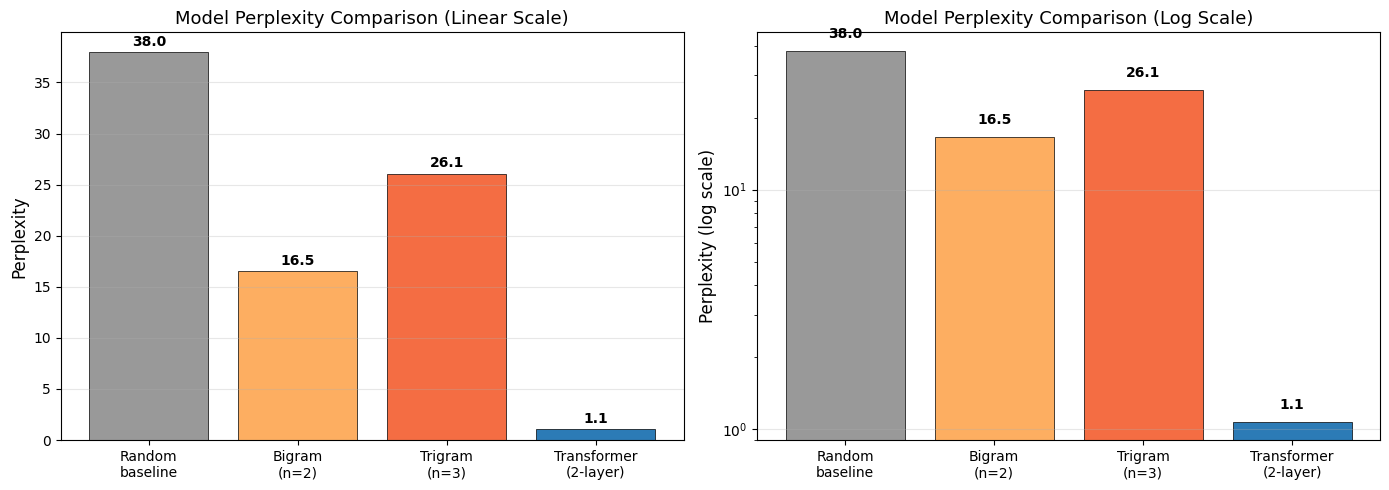


Key observations:
  - The Transformer achieves 35.4x lower perplexity than random guessing.
  - The Transformer achieves 15.4x lower perplexity than the bigram model.
  - Even the trigram model, which only uses 2 characters of context, does much
    better than random, showing that character sequences are highly predictable.
  - The Transformer's ability to attend to 64 characters of context gives
    it a significant advantage over fixed-window n-gram models.


In [27]:
# --- Visualise the perplexity comparison ---

models = ['Random\nbaseline', 'Bigram\n(n=2)', 'Trigram\n(n=3)', 'Transformer\n(2-layer)']
perplexities = [V, bigram_ppl_eval, trigram_ppl_eval, trans_ppl]
colors = ['#999999', '#fdae61', '#f46d43', '#2c7bb6']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart (linear scale)
bars = axes[0].bar(models, perplexities, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_ylabel('Perplexity', fontsize=12)
axes[0].set_title('Model Perplexity Comparison (Linear Scale)', fontsize=13)
axes[0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, perplexities):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                 f"{val:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Bar chart (log scale)
bars = axes[1].bar(models, perplexities, color=colors, edgecolor='black', linewidth=0.5)
axes[1].set_ylabel('Perplexity (log scale)', fontsize=12)
axes[1].set_title('Model Perplexity Comparison (Log Scale)', fontsize=13)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, perplexities):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.1,
                 f"{val:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"  - The Transformer achieves {V / trans_ppl:.1f}x lower perplexity than random guessing.")
print(f"  - The Transformer achieves {bigram_ppl_eval / trans_ppl:.1f}x lower perplexity than the bigram model.")
print(f"  - Even the trigram model, which only uses 2 characters of context, does much")
print(f"    better than random, showing that character sequences are highly predictable.")
print(f"  - The Transformer's ability to attend to {BLOCK_SIZE} characters of context gives")
print(f"    it a significant advantage over fixed-window n-gram models.")

---
## Summary

In this notebook, we have built up the core components of a large language model from scratch:

| Component | Key Idea |
|-----------|----------|
| **BPE Tokenisation** | Bottom-up vocabulary construction by iteratively merging frequent pairs |
| **N-gram Models** | Count-based probability estimation with smoothing; limited context window |
| **Neural LM (Feedforward)** | Dense embeddings + neural network overcome the curse of dimensionality |
| **Attention** | Soft lookup mechanism; scaled dot-product; causal masking for autoregression |
| **Transformer** | Combines attention, FFN, residual connections, layer norm into a powerful architecture |
| **Perplexity** | Standard evaluation metric; measures how well the model predicts held-out text |

**Next week:** We will explore how to scale these ideas to larger models and study fine-tuning, RLHF, and the training pipeline of modern LLMs in the context of financial applications.